In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd
from PIL import Image

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#!pip install -e .
#pip install  course_ocr_t3

from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import wandb
import pandas as pd

import torch

In [5]:
DATASET_PATH = Path('/') / 'DATA' / 'asaginbaev' / 'CourseOCRTask3' 

TRAIN_PATH, TEST_PATH = DATASET_PATH / 'Train', DATASET_PATH / 'Test'

assert DATASET_PATH.exists(), DATASET_PATH.absolute()
assert TRAIN_PATH.exists(), TRAIN_PATH.absolute()
assert TEST_PATH.exists(), TEST_PATH.absolute()

In [6]:
from torchvision.transforms import Resize, Compose, ToTensor
import torch.nn as nn
from task3pack.utils.data import SegmentationDataset

IMAGE_SIZE = [512, 512]
NAMES = ['path', 'code', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'barcode']

image_transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

target_transforms = Compose([
    Resize(IMAGE_SIZE),   
])

train_dataset = SegmentationDataset(csv_path=TRAIN_PATH / 'markup.csv', images_path=TRAIN_PATH / 'Images', csv_header=NAMES, csv_encoding='utf-16', 
                                   image_transforms=image_transforms, target_transforms=target_transforms, shape=IMAGE_SIZE)
test_dataset = SegmentationDataset(csv_path=None, images_path=TEST_PATH / 'Images', csv_header=NAMES, csv_encoding='utf-16', 
                                   image_transforms=image_transforms, target_transforms=target_transforms, shape=IMAGE_SIZE, is_test=True)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)
print(test_dataset[0][0].shape, test_dataset[0][1])

val_ratio = 0.1
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

print(train_size, val_size)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
        [train_size, val_size])

8199 100
torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([3, 512, 512]) 1105913212699e2e8a558191113acbd7.png
7380 819


In [12]:
test_image = Image.open(TEST_PATH / 'Images' / res_markup.loc[0, 'path'])

In [174]:
TEST_PATH / 'Images' / res_markup.loc[0, 'path']

PosixPath('/DATA/asaginbaev/CourseOCRTask3/Test/Images/5825c9d1deb6572b6dba440d5c6482bf.png')

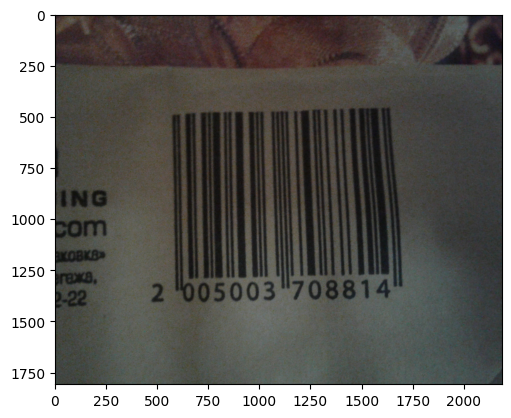

In [13]:
plt.imshow(test_image)

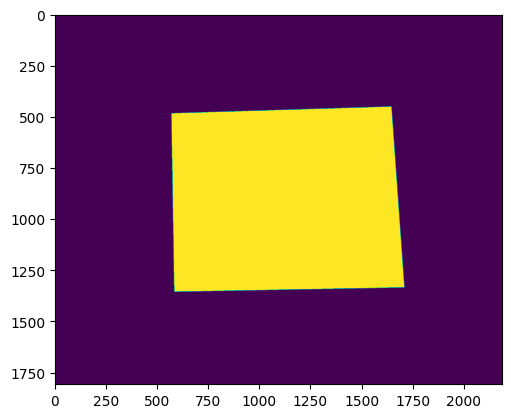

In [14]:
coords = res_markup.loc[0, ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']].to_numpy(dtype=int).reshape(4, 2)
target = np.zeros((test_image.size[1], test_image.size[0]))
target = torch.FloatTensor(cv2.fillConvexPoly(target, coords, (1, )))
plt.imshow(target)

In [22]:
def four_point_transform(image, rect):
    # obtain a consistent order of the points and unpack them
    # individually
    #rect = order_points(pts)
    image = np.array(image)
    tl, tr, br, bl = rect[0, :], rect[1, :], rect[2, :], rect[3, :]

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [23]:
warped = four_point_transform(test_image, coords.astype('float32'))

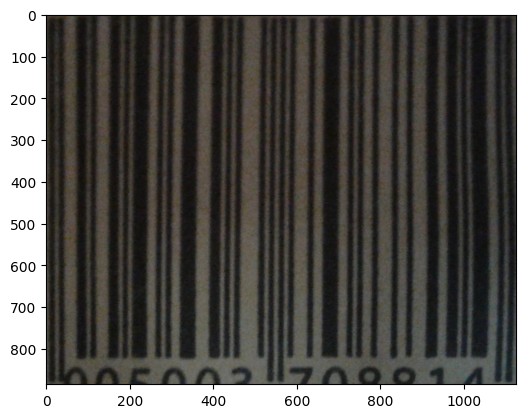

In [25]:
plt.imshow(warped)

In [176]:
from tqdm import tqdm


def get_hists(image, thresh_hist=99, thresh_image=50):
    image = cv2.resize(image, (1200, 1000))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    th, image_th = cv2.threshold(image_gray, thresh_image, 255, cv2.THRESH_BINARY)
    
    #images = []
    hists = []
    for i in range(1000 // 100):
        img_crop = image_th[i * 100: (i + 1) * 100, :]
        vertical_pixel_sum = np.sum(img_crop, axis=0)
        myprojection = vertical_pixel_sum / 255
        myprojection = np.where(myprojection > thresh_hist, 1, 0)
        
        #images.append(img_crop)
        hists.append(myprojection[np.newaxis, ...])
        
    return np.concatenate(hists, axis=0)


def dump_hists_to_npy(csv_path, images_path, csv_header):
    X = []
    y = []
    
    markup = pd.read_csv(csv_path, header=None, encoding='utf-16', names=csv_header)
    for idx in tqdm(range(len(markup))):
        image_path = images_path / markup.loc[idx, 'path']
        
        if image_path.exists():
            image = Image.open(image_path)
            coords = markup.loc[idx, ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']].to_numpy(dtype='float32').reshape(4, 2)
            warped_image = four_point_transform(image, coords)
            hists = get_hists(warped_image)
            resX = np.concatenate(hists[3:-3], axis=0)
            
            label = str(markup.loc[idx, 'code'])
            
            for _ in range(13 - len(label)):
                label = '0' + label
                
            resy = []
            for char in label:
                resy.append(int(char))
            
            X.append(resX)
            y.append(resy)
        
    return np.array(X), np.array(y)

# Work with reference bboxes

In [158]:
X_train, y_train = dump_hists_to_npy(TRAIN_PATH / 'markup.csv', TRAIN_PATH / 'Images', NAMES)
X_train.dump('X_train_ref.npy')
y_train.dump('y_train_ref.npy')

100%|███████████████████████████████████████████████████████████████████████████████| 8199/8199 [25:26<00:00,  5.37it/s]


In [177]:
X_test, y_test = dump_hists_to_npy('markup.csv', TEST_PATH / 'Images', NAMES)
X_test.dump('X_test_ref.npy')
y_test.dump('y_test_ref.npy')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_scoreuracy_score
import sklearn
import numpy as np

In [7]:
X_train, y_train = np.load('./X_train_ref.npy', allow_pickle=True), np.load('./y_train_ref.npy', allow_pickle=True)
X_test, y_test = np.load('./X_test_ref.npy', allow_pickle=True), np.load('./y_test_ref.npy', allow_pickle=True)

## XGBoost

In [9]:
xgbclassifier = XGBClassifier()
xgbclassifier.fit(X_train, y_train[:, 0])

accuracy_score(xgbclassifier.predict(X_test), y_test[:, 0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
xgbs = []
for i in range(y_train.shape[1]):
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train[:, i])

    print(i, accuracy_score(xgbc.predict(X_test), y_test[:, i]))
    xgbs.append(xgbc)

0 0.86
1 0.86
2 0.84
3 0.78
4 0.74
5 0.66
6 0.58


## Pytorch model

In [113]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        loss = model.loss(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            
            loss = model.loss(x, y)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args, device):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader, device)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer, device))
        test_loss = eval_loss(model, test_loader, device)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_dataset, test_dataset, model, train_dataloader_kwargs, test_dataloader_kwargs, training_kwargs, device='cpu'):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss and accept
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    model.to(device)
    test_losses = []
    train_losses = []

    train_dataloader = DataLoader(train_dataset, **train_dataloader_kwargs)
    test_dataloader = DataLoader(test_dataset, **test_dataloader_kwargs)

    test_losses.append(eval_loss(model, test_dataloader, device))

    train_loss, test_loss = train_epochs(model, train_dataloader, test_dataloader, training_kwargs, device)
    test_losses += test_loss
    train_losses += train_loss

    return np.array(train_losses), np.array(test_losses), model

In [124]:
train_dataloader_config = {
    'batch_size': 128,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 128,
    'shuffle': False,
}

learning_config = {
    'lr': 1e-3,
    'epochs': 100,
}

device = 'cpu'

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, n_outputs=13, n_classes=10):
        super().__init__()
        self.n_outputs = n_outputs
        self.n_classes = n_classes
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, n_outputs * n_classes)
        )
    
    def forward(self, x):
        logits = self.model(x)
        
        #result = torch.zeros(x.shape[0], self.n_outputs)
        #for i in range(self.n_outputs):
        #    result[:, i] = torch.argmax(logits[:, i * self.n_classes: (i + 1) * self.n_classes], dim=-1)
         
        result = torch.argmax(logits, -1)    
            
        return result
    
    def loss(self, x, y):
        logits = self.model(x)
        
        #loss = torch.zeros(self.n_outputs)
        #for i in range(self.n_outputs):
        #    loss[i] = F.cross_entropy(logits[:, i * self.n_classes: (i + 1) * self.n_classes], y[:, i])
            
        
        #return loss.sum()
        return F.cross_entropy(logits, y)

In [142]:
model = Perceptron(4800, n_outputs=1)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train[:, 0]))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test[:, 0]))

In [143]:
for x, y in test_dataset:
    pred = model(x[None, ...])
    print(pred, y)

tensor([0]) tensor(2)
tensor([2]) tensor(8)
tensor([2]) tensor(4)
tensor([8]) tensor(4)
tensor([0]) tensor(9)
tensor([2]) tensor(9)
tensor([8]) tensor(9)
tensor([2]) tensor(9)
tensor([7]) tensor(9)
tensor([7]) tensor(9)
tensor([7]) tensor(9)
tensor([8]) tensor(9)
tensor([4]) tensor(9)
tensor([8]) tensor(9)
tensor([8]) tensor(2)
tensor([2]) tensor(4)
tensor([7]) tensor(4)
tensor([8]) tensor(9)
tensor([8]) tensor(9)
tensor([7]) tensor(9)
tensor([2]) tensor(9)
tensor([8]) tensor(4)
tensor([8]) tensor(4)
tensor([2]) tensor(2)
tensor([8]) tensor(5)
tensor([8]) tensor(4)
tensor([8]) tensor(4)
tensor([8]) tensor(4)
tensor([8]) tensor(4)
tensor([2]) tensor(4)
tensor([2]) tensor(4)
tensor([8]) tensor(2)
tensor([9]) tensor(4)
tensor([8]) tensor(8)
tensor([8]) tensor(3)
tensor([7]) tensor(4)
tensor([7]) tensor(4)
tensor([8]) tensor(6)
tensor([2]) tensor(8)
tensor([8]) tensor(4)
tensor([2]) tensor(4)
tensor([2]) tensor(4)
tensor([7]) tensor(4)
tensor([2]) tensor(4)
tensor([7]) tensor(4)
tensor([1]

In [144]:
train_losses, test_losses, trained_model = train_model(train_dataset, test_dataset, model, train_dataloader_config, test_dataloader_config, learning_config, device=device)

epoch 0 started
train loss: 1.4773058992165786, test_loss: 1.06034517288208
epoch 1 started
train loss: 1.3049280437139363, test_loss: 0.8303654193878174
epoch 2 started
train loss: 1.2280073911715776, test_loss: 1.0126780271530151
epoch 3 started
train loss: 1.1766092648872963, test_loss: 0.7694059610366821
epoch 4 started
train loss: 1.1387277578390562, test_loss: 0.674325704574585
epoch 5 started
train loss: 1.106904990474383, test_loss: 0.7526496052742004
epoch 6 started
train loss: 1.0856591324884812, test_loss: 0.7652541399002075
epoch 7 started
train loss: 1.0641921502466385, test_loss: 0.6311178207397461
epoch 8 started
train loss: 1.0460156166145944, test_loss: 0.6680603623390198
epoch 9 started
train loss: 1.0313146598980978, test_loss: 0.798119306564331
epoch 10 started
train loss: 1.020482488320424, test_loss: 0.6402899026870728
epoch 11 started
train loss: 1.0076323012893016, test_loss: 0.5753074884414673
epoch 12 started
train loss: 0.9964156274259444, test_loss: 0.603819

In [145]:
for x, y in test_dataset:
    pred = trained_model(x[None, ...])
    print(pred, y)

tensor([2]) tensor(2)
tensor([2]) tensor(8)
tensor([4]) tensor(4)
tensor([6]) tensor(4)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([6]) tensor(2)
tensor([6]) tensor(4)
tensor([4]) tensor(4)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([9]) tensor(9)
tensor([4]) tensor(4)
tensor([5]) tensor(4)
tensor([2]) tensor(2)
tensor([2]) tensor(5)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([2]) tensor(2)
tensor([4]) tensor(4)
tensor([4]) tensor(8)
tensor([4]) tensor(3)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([6]) tensor(6)
tensor([6]) tensor(8)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([4]) tensor(4)
tensor([6]) tensor(4)
tensor([4]) tensor(4)
tensor([8]